In [17]:
import numpy as np
import tensorflow as tf
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow_addons.losses import metric_learning
import tensorflow_probability as tfp
from keras import backend as K
import os
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.metrics import precision_recall_curve
import uuid

all_features = []
feature_name = ['p90','p95','p80','p5','p10','p20','range_90_to_80','range_20_to_10','range_90_to_10',
                'range_80_to_20','median','iqr','skew']
name = 'current_window_stress'
all_features += [name+'_'+a for a in feature_name]
# print(len(set(all_features)),len(all_features))
name = 'current_window_stress_diff'
all_features += [name+'_'+a for a in feature_name]
name = 'daily_stress'
all_features += [name+'_'+a for a in feature_name]
all_features += ['percentage_of_stress', 'maximum_duration_of_current_stress_episode','average_duration_of_current_stress_episode',
               'maximum_density_of_current_stress_episode', 'average_density_of_current_stress_episode', 'average_deviation_to_daily_mean_current',
               'no_stress_till_now', 'time_since_last_stress', 'duration_of_last_stress_episode', 'average_duration_of_before_stress_episode',
               'density_of_last_stress_episode', 'average_density_of_before_stress_episode', 'deviation_to_daily_mean_of_last_stress_episode',
               'percentage_of_stress_before']
all_features+= ['percentage_of_active_', 'maximum_duration_of_current_activity_episode', 'average_duration_of_current_window_episode',
                 'no_activity_till_now', 'time_since_last_activity', 'duration_of_last_activity_episode', 'average_duration_of_before_activity_episode',
                 'percentage_of_active_before']
all_features += ['time_since_last_visit_smoking_spot','duration_of_stay_in_smoking_spot','fraction_of_minutes_spent_in_smoking_spots_out_of_observed']
all_features += ['Gender','Age']
all_features += ['is_smoking','spread','distance_to_nearest_spot',
                'time_spent_in_transition','time_spent_in_smoking_spot']
all_features += ['Time of day = {}'.format(a) for a in np.arange(24)]
feature_names = all_features


def get_X_y_groups(n_lag=10):
    data = pickle.load(open(filepath_file.format(n_lag),'rb'))

    X_feature = np.concatenate(data.feature_final.values)
    X_static =  np.concatenate(data.static_features.values)

    X_stress_episode = np.concatenate(data.stress_episode.values)
    X_quit_episode = np.concatenate(data.quit_episode.values)
    X_activity_episode = np.concatenate(data.activity_episode.values)
    X_smoking_episode = np.concatenate(data.smoking_episode.values)

    y_time = data['time'].values
    y = data['label'].values
    groups = data['user'].values
    
    return X_feature,X_static,X_stress_episode,X_quit_episode,X_activity_episode,X_smoking_episode,y_time,y,groups

def get_train_test_indexes(groups,n_groups_split = 10,n_val_groups = 10):
    groups_unique = np.unique(groups)
    groups_split = np.array_split(groups_unique,n_groups_split)
    indexes = []
    for this_groups in groups_split:
        train_groups = np.array([a for a in groups_unique if a not in this_groups])
        val_groups = np.random.choice(train_groups,n_val_groups)
        train_groups = np.array([a for a in groups_unique if a not in list(this_groups)+list(val_groups)])
        test_groups = this_groups
        train_index,test_index = np.array([i for i,a in enumerate(groups) 
                                           if a in train_groups]),np.array([i for i,a in enumerate(groups) 
                                                                               if a in test_groups])
        val_index = np.array([i for i,a in enumerate(groups) 
                                           if a in val_groups])
        indexes.append([train_index,test_index,val_index])
    return indexes


def get_train_test_indexes(groups,n_groups_split = 10,n_val_groups = 10):
    groups_unique = np.unique(groups)
    groups_split = np.array_split(groups_unique,n_groups_split)
    indexes = []
    for this_groups in groups_split:
        train_groups = np.array([a for a in groups_unique if a not in this_groups])
        val_groups = np.random.choice(train_groups,n_val_groups)
        train_groups = np.array([a for a in groups_unique if a not in list(this_groups)+list(val_groups)])
        test_groups = this_groups
        train_index,test_index = np.array([i for i,a in enumerate(groups) 
                                           if a in train_groups]),np.array([i for i,a in enumerate(groups) 
                                                                               if a in test_groups])
        val_index = np.array([i for i,a in enumerate(groups) 
                                           if a in val_groups])
        indexes.append([train_index,test_index,val_index])
    return indexes

class CenterLoss(tf.keras.losses.Loss):
    def __init__(
        self,
        alpha=0.9,
        update_centers=True,
        p = 80,
        name="center_loss",
        **kwargs
    ):
        super().__init__(name=name, **kwargs)
        self.alpha = alpha
        self.update_centers = update_centers
        self.p = p
        
    def consistency_loss(self,labels,precise_embeddings):
        
        lshape = tf.shape(labels)
        labels = tf.reshape(labels, [lshape[0], 1])
        mask_for_equal = tf.math.equal(tf.cast(labels,tf.bool),tf.transpose(tf.cast(labels,tf.bool)))
        only_positive = tf.repeat(tf.transpose(tf.reshape(tf.cast(labels,tf.bool),[lshape[0],1])),lshape[0],axis=0)
        mask_only_positive = tf.math.multiply(tf.cast(mask_for_equal,tf.float32),tf.cast(only_positive,tf.float32))
        
        pdist_matrix = metric_learning.pairwise_distance(
                    precise_embeddings, squared=False
                )
        positive_only_dist = tf.boolean_mask(pdist_matrix, tf.cast(mask_only_positive,tf.bool))
        no_of_positives = tf.cast(tf.reduce_sum(labels),tf.int32)
        positive_only_dist = tf.reshape(positive_only_dist,[no_of_positives,no_of_positives])
        positive_only_dist = tf.reduce_mean(positive_only_dist,axis=1)
        
        distance_95 = tf.reshape(positive_only_dist,(-1,))
        # if max_vs_percentile:
        #     return tf.reduce_max(distance_95),pdist_matrix
        return tfp.stats.percentile(distance_95,self.p),pdist_matrix
        
    
    def compute_rare_loss_v1(self,labels,pdist_matrix,positive_dist_95th):
        lshape = tf.shape(labels)
        labels = tf.reshape(labels, [lshape[0], 1])
        mask_for_equal = tf.math.equal(tf.cast(labels,tf.bool),tf.transpose(tf.cast(labels,tf.bool)))
        only_negative = tf.cast(tf.repeat(tf.transpose(tf.reshape(tf.cast(1-labels,tf.bool),[lshape[0],1])),lshape[0],axis=0),tf.int32)
        mask_negative_to_positive = tf.math.logical_not(tf.cast(tf.math.add(tf.cast(mask_for_equal,tf.int32),only_negative),tf.bool))
        no_of_positives = tf.cast(tf.reduce_sum(labels),tf.int32)
        no_of_negatives = lshape[0] - no_of_positives
        negative_to_positive_distance = tf.reshape(tf.boolean_mask(pdist_matrix,mask_negative_to_positive),[no_of_negatives,no_of_positives])
        average_neg_to_pos_distance = tf.reduce_mean(negative_to_positive_distance,axis=1)
        less_distance_mask = tf.reduce_sum(tf.where(average_neg_to_pos_distance<=positive_dist_95th,1,0))
        return tf.cast(less_distance_mask,tf.float32)/(tf.cast(no_of_negatives,tf.float32)+K.epsilon())
    def call(self, sparse_labels, prelogits):
        sparse_labels = tf.reshape(sparse_labels, (-1,))
        distance_95th, pdist_matrix = self.consistency_loss(sparse_labels,prelogits)
        rare_loss = self.compute_rare_loss_v1(sparse_labels,pdist_matrix,distance_95th)
        return tf.square(rare_loss-ratio_of_pos_to_neg) + distance_95th*.2

def get_model():
    n_t,n_f = train_feature.shape[1],train_feature.shape[2]
    print(n_t,n_f)
    x_input = Input(shape=(n_t,n_f))
    x_feature = Conv1D(100,1,activation='linear')(x_input)
    x_feature = Conv1D(100,1,activation='tanh')(x_feature)
    # x_feature = Dropout(.2)(x_feature)
    x_feature = LSTM(10,activation='tanh',return_sequences=False)(x_feature)
    x_feature = Dropout(.2)(x_feature)
    x_feature = Flatten()(x_feature)
    # x_feature = Dense(10,activation='relu')(x_feature)
    merged_all = x_feature
    merged1 = Dense(10,activation='relu',name='normalize2')(merged_all)
    merged1 = Lambda(lambda x: K.l2_normalize(x,axis=1),name='normalize3')(merged1)
    merged = Dense(5,activation='relu',name='normalize')(merged1)
    output = Dense(1,activation='sigmoid',name='softmax')(merged)
    model = tf.keras.models.Model(inputs=[x_input], outputs=[output,merged1])
    myloss1 = CenterLoss()
    model.compile(
        loss={'softmax':tf.losses.BinaryCrossentropy(),'normalize3':myloss1},
        loss_weights = {'softmax':softmax_weight,'normalize3':revised_loss_weight},
        metrics={'softmax':['acc']},
        optimizer='adam'
        )
    return model
    
def f1Bias_scorer_CV(probs, y, ret_bias=True):
    precision, recall, thresholds = precision_recall_curve(y, probs)

    f1,bias = 0.0,.5
    min_recall = .8
    for i in range(0, len(thresholds)):
        if not (precision[i] == 0 and recall[i] == 0) and thresholds[i]>0.2:
            f = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
            if f > f1:
                f1 = f
                bias = thresholds[i]

    if ret_bias:
        return f1, bias
    else:
        return f1
def set_gpu():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
    # Restrict TensorFlow to only use the first GPU
        try:
            tf.config.experimental.set_visible_devices(gpus[gpu_id], 'GPU')
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
        except RuntimeError as e:
            # Visible devices must be set before GPUs have been initialized
            print(e)
import warnings
warnings.filterwarnings('ignore')
n_lag = 15
obs = 30
n_cluster = 4
n_iters = 2
softmax_weight = 10
revised_loss_weight = 50
batch_size = 200
n_epochs = 100
n_step = 20
ratio_of_pos_to_neg = .35
gpu_id = 0
set_gpu()
# tf.compat.v1.disable_v2_behavior()
# tf.compat.v1.disable_eager_execution()
filepath_file = './data/episode_encoded_lagged_data_without_episode/episode_encoded_'+'lagged_'+str(n_lag)+'_obs_{}'.format(obs)+'_windows_with_episode_cluster_check_{}'.format(n_cluster)
X_feature,X_static,X_stress_episode,X_quit_episode,X_activity_episode,X_smoking_episode,y_time,y,groups = get_X_y_groups(n_lag)
X_feature = np.nan_to_num(X_feature)
indexes = get_train_test_indexes(groups,n_groups_split = 3,n_val_groups=8)
save_dir = '_'.join([str(softmax_weight),str(revised_loss_weight),str(ratio_of_pos_to_neg*100)])
model_save_path = './explannation_models/'+save_dir+'/'
if not os.path.isdir(model_save_path):
    os.makedirs(model_save_path)
for kk,yyyy in enumerate(indexes):
    if not os.path.isdir(model_save_path+str(kk)):
        os.makedirs(model_save_path+str(kk))
    model_save_path_this = model_save_path+str(kk)+'/'
    train_index,test_index,val_index = yyyy
    X_feature_train,X_feature_test = X_feature[train_index],X_feature[test_index]
    X_static_train,X_static_test = X_static[train_index],X_static[test_index]
    X_stress_episode_train,X_stress_episode_test = X_stress_episode[train_index], X_stress_episode[test_index]
    X_quit_episode_train,X_quit_episode_test = X_quit_episode[train_index], X_quit_episode[test_index]
    X_activity_episode_train,X_activity_episode_test = X_activity_episode[train_index], X_activity_episode[test_index]
    X_smoking_episode_train,X_smoking_episode_test = X_smoking_episode[train_index], X_smoking_episode[test_index]
    y_train,y_test,groups_train,groups_test,time_train,time_test = y[train_index],y[test_index],groups[train_index],groups[test_index],y_time[train_index],y_time[test_index]
    
    X_feature_val,X_static_val,X_stress_episode_val,X_quit_episode_val,\
    X_activity_episode_val,X_smoking_episode_val,y_val,groups_val,time_val = X_feature[val_index],X_static[val_index],X_stress_episode[val_index],X_quit_episode[val_index],\
                                                                            X_activity_episode[val_index],X_smoking_episode[val_index],y[val_index],groups[val_index],y_time[val_index]
    
    X_feature_train,val_feature,\
    X_static_train,val_static,\
    X_stress_episode_train,val_stress,\
    X_smoking_episode_train,val_smoking,\
    X_quit_episode_train,val_quit,\
    X_activity_episode_train,val_activity, \
    y_train,val_y = train_test_split(
                                    X_feature_train,
                                    X_static_train,
                                    X_stress_episode_train,
                                    X_smoking_episode_train,
                                    X_quit_episode_train,
                                    X_activity_episode_train,
                                    y_train,
                                    test_size=.05,
                                    stratify=y_train
                                    )
    val_feature = np.concatenate([val_feature,X_feature_val])
    val_static = np.concatenate([val_static,X_static_val])
    val_stress = np.concatenate([val_stress,X_stress_episode_val])
    val_activity = np.concatenate([val_activity,X_activity_episode_val])
    val_smoking = np.concatenate([val_smoking,X_smoking_episode_val])
    val_quit = np.concatenate([val_quit,X_quit_episode_val])
    val_y = np.array(list(val_y)+list(y_val))
    
    positive_train_index = np.where(y_train==1)[0]
    negative_train_index = np.where(y_train==0)[0]
    len_positive = len(positive_train_index)
    all_models = []
    model_col = {}
    for iter in range(n_iters):
        indexes_sampled = np.array(list(positive_train_index)+list(np.random.choice(negative_train_index,len_positive,replace=False)))
        train_feature = np.float64(X_feature_train[indexes_sampled])
        train_static = X_static_train[indexes_sampled]
        train_stress = X_stress_episode_train[indexes_sampled]
        train_quit = X_quit_episode_train[indexes_sampled]
        train_activity = X_activity_episode_train[indexes_sampled]
        train_smoking = X_smoking_episode_train[indexes_sampled]
        train_y = np.float64(y_train[indexes_sampled])
        model = get_model()
        # model.summary()
        validation_results = [0]
        counter_ = 0
        best_filepath = None
        for iiii in np.arange(0,n_epochs,n_step):
            filepath = './models/lag_'+str(n_lag)+'_iter_'+str(n_iters)+'_temp_with_episode_revised_loss_80_.2{}{}{}{}.hdf5'.format(softmax_weight,revised_loss_weight,ratio_of_pos_to_neg,iiii)
            checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True, mode='min',save_weights_only=False)
            es = EarlyStopping(monitor='loss', mode='min', verbose=1,patience=60)
            callbacks_list = [es,checkpoint]
            model.fit(train_feature,train_y,
                      epochs=n_step, batch_size=batch_size,
                      verbose=0,callbacks=callbacks_list,shuffle=True)
            if os.path.isfile(filepath):
                model.load_weights(filepath)
            val_y_pred = model.predict(val_feature)[0]
            val_f1_now = f1Bias_scorer_CV(val_y_pred,val_y)[0]
            # print('<->'*20)
            from sklearn.metrics import roc_auc_score
            print('Validation Result now',val_f1_now,'AUC',roc_auc_score(val_y,val_y_pred),'step',iiii,'stagnant',counter_)
            # print('<->'*20)
            if val_f1_now>=max(validation_results):
                best_filepath = filepath
                counter_ = 0
            else:
                counter_ += n_step
                if counter_>200:
                    break
            validation_results.append(val_f1_now)
        if os.path.isfile(best_filepath):
            print(best_filepath[-15:])
            model.load_weights(best_filepath)
        model_this_iter = tf.keras.models.Model(model.input,model.get_layer('softmax').output)
        model_path = model_save_path_this+str(iter)+'.h5'
        model_this_iter.save_weights(model_path)
        json_model = model_this_iter.to_json()
        #save the model architecture to JSON file
        with open(model_save_path_this+'model.json', 'w') as json_file:
            json_file.write(json_model)
        model_col[model_path] = [train_feature,train_y]
        pickle.dump([model_col,X_feature_test,y_test],open(model_save_path_this+'data.p','wb'))
        # all_models.append(model_this_iter)
        
        # print(len(all_models))

4 Physical GPUs, 1 Logical GPU
15 95
Validation Result now 0.11601620814672638 AUC 0.453935799744854 step 0 stagnant 0
Validation Result now 0.13496932515337423 AUC 0.5214597053178407 step 20 stagnant 0
Validation Result now 0.14560669456066946 AUC 0.5431456803319197 step 40 stagnant 0
Validation Result now 0.13971291866028707 AUC 0.5509731751887736 step 60 stagnant 0
Validation Result now 0.13660531697341516 AUC 0.5545942086450827 step 80 stagnant 20
10500.3540.hdf5
15 95
Validation Result now 0.16458852867830423 AUC 0.5899450775207162 step 0 stagnant 0
Validation Result now 0.17321248741188316 AUC 0.6197078032157594 step 20 stagnant 0
Validation Result now 0.13617021276595745 AUC 0.5701105632750636 step 40 stagnant 0
Validation Result now 0.17607223476297967 AUC 0.5926337361652243 step 60 stagnant 20
Validation Result now 0.15384615384615385 AUC 0.6065855974669286 step 80 stagnant 0
10500.3560.hdf5
15 95
Validation Result now 0.14328808446455504 AUC 0.5100782172146199 step 0 stagnant

In [18]:
model_this_iter.summary()

Model: "model_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 15, 95)]          0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 15, 100)           9600      
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 15, 100)           10100     
_________________________________________________________________
lstm_17 (LSTM)               (None, 10)                4440      
_________________________________________________________________
dropout_17 (Dropout)         (None, 10)                0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 10)                0         
_________________________________________________________________
normalize2 (Dense)           (None, 10)                110

In [19]:
# d_ = pickle.load(open('/home/azim/mrisk/explannation_models/10_50_35.0/0/data.p','rb'))
import tensorflow as tf
from alibi.explainers import IntegratedGradients


In [20]:
ig  = IntegratedGradients(model_this_iter,
                          method="gausslegendre",
                          n_steps=50,
                          internal_batch_size=100)

In [21]:
explanation = ig.explain(X_feature_test)

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


In [22]:
import shap

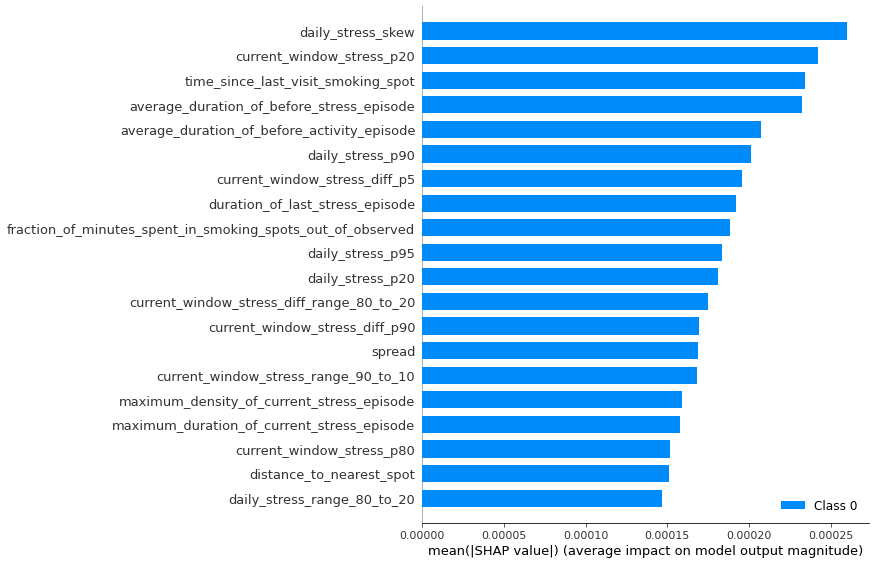

In [25]:
shap.summary_plot([explanation.attributions.mean(axis=1)], X_feature_test.mean(axis=1),feature_names=feature_names)


In [ ]:
# all_models = []
# all_models.append(model_this_iter)
model_input = all_models[0].input
model_outputs = [model(model_input) for model in all_models]
ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)
ensemble_model.predict(val_feature).shape
val_feature.shape
ensemble_model.summary()
import shap

# we use the first 100 training examples as our background dataset to integrate over
explainer = shap.DeepExplainer(ensemble_model,X_feature_train)

# explain the first 10 predictions
# explaining each prediction requires 2 * background dataset size runs
shap_values = explainer.shap_values(X_feature_test)
# shap_values[0].sum(axis=1).
# 
shap.summary_plot(shap_values[0].mean(axis=1), X_feature_test.mean(axis=1),feature_names=feature_names)

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0].sum(axis=1)[0], val_feature.mean(axis=1)[0],feature_names=feature_names)
?shap.summary_plot
import shutil
shutil.rmtree('./models/')